# Se agregaron variables:
* On-Balance Volume (OBV): Este indicador relaciona el volumen de operaciones con el movimiento del precio, ofreciendo información sobre la fuerza detrás de una tendencia. Es útil para predecir si una tendencia se está reforzando o debilitando.
* Average True Range (ATR): Este indicador mide la volatilidad del precio, proporcionando información valiosa sobre el nivel de riesgo. Una alta volatilidad puede indicar movimientos bruscos en el mercado, mientras que la baja volatilidad podría sugerir estabilidad.

In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    Nuevos Cambios:
       On-Balance Volume (OBV): Este indicador relaciona el volumen de operaciones con el movimiento del precio, ofreciendo información sobre la fuerza detrás de una tendencia. Es útil para predecir si una tendencia se está reforzando o debilitando.
       Average True Range (ATR): Este indicador mide la volatilidad del precio, proporcionando información valiosa sobre el nivel de riesgo. Una alta volatilidad puede indicar movimientos bruscos en el mercado, mientras que la baja volatilidad podría sugerir estabilidad.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.expand_dims(field=["trend"])

    # moving average convergence divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").expand_dims(field=["macd"])

    # volatility adjusted to ensure compatibility with lwma:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14).expand_dims(field=["volatility"])

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.expand_dims(field=["stochastic_d"])

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close")).expand_dims(field=["rsi"])

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price).expand_dims(field=["price"])

    # new variable: On-Balance Volume (OBV):
    obv = qnta.obv(data.sel(field="close"), data.sel(field="vol")).expand_dims(field=["obv"])

    # new variable: Average True Range (ATR):
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14).expand_dims(field=["atr"])

    # combine the features:
    result = xr.concat(
        [trend, macd2_signal, volatility, d, rsi, price, obv, atr],
        dim="field"
    )

    return result.transpose("time", "field", "asset")

# Se cambio la tecnica de machine learning:
He elegido `MLPClassifier` porque las redes neuronales son técnicas avanzadas que pueden modelar relaciones no lineales complejas.
        Son robustas y escalables, estas ventajas hacen que sean ideales para identificar patrones en conjuntos de datos ricos y diversos, como los del mercado financiero.

In [ ]:
def get_model():
    """Este es un constructor para el modelo de ML (Red Neuronal Multicapa - MLPClassifier).
    Explicación:
        He elegido `MLPClassifier` porque las redes neuronales son técnicas avanzadas que pueden modelar relaciones no lineales complejas.
        Son robustas y escalables, y pueden ajustarse con hiperparámetros como el número de capas y neuronas por capa, lo que permite optimizar su desempeño.
        Estas ventajas hacen que sean ideales para identificar patrones en conjuntos de datos ricos y diversos, como los del mercado financiero.
    """
    model = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', max_iter=500, random_state=42)
    return model

# Se cambio a S&P 500 y los activos se filtraron solo a los activos líquidos:
He decidido cargar todos los activos del S&P 500 para evitar problemas con activos no disponibles y usar todo el mercado disponible.

In [ ]:
# loading s&p 500 stock data

stock_data = qndata.stocks.load_spx_data(min_date="2006-01-01")

# Filtrar solo los activos líquidos
is_liquid = stock_data.sel(field='is_liquid')
stock_data = stock_data.where(is_liquid)

# Explicación:
# He decidido cargar todos los activos del S&P 500 para evitar problemas con activos no disponibles.

# Se aceptan cortos:

In [ ]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down more than 0.1%."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1  # prices go up more than 0.1%
    class_neutral = 0   # prices go up or down less than or equal to 0.1%
    class_negative = -1 # prices go down more than 0.1%

    target_price_up = xr.where(
        price_future > price_current * 1.001, class_positive,
        xr.where(price_future < price_current * 0.999, class_negative, class_neutral)
    )

    return target_price_up

# Resultados:


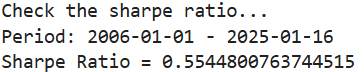

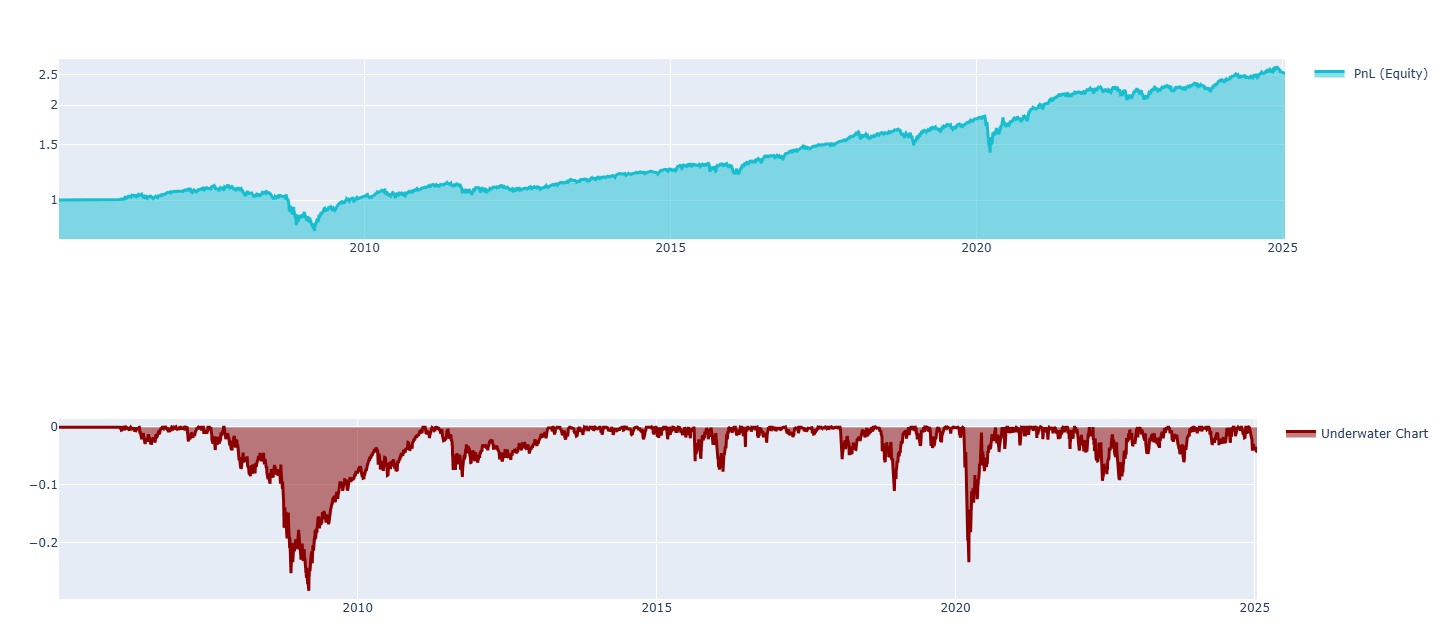